In [1]:
# -------------- Mini Project #1 -----------
# import all required libraries to analyse data, plot, model, calculate error etc
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
#read input data from the given .csv file
df = pd.read_csv("insurance data.csv")

#inspect data info to understand nature of data present in the input file
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [3]:
# display more information about the data
df.info()

# see how many unique values are there in each of the columns
df.nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


age           47
sex            2
bmi          548
children       6
smoker         2
region         4
charges     1337
dtype: int64

In [4]:
# from the above, we info we see that there are no NULL or NaN values in the data - so we are good here...

# next on inspecting the data, we see that the columns sex, smoker and region are strings (object type)
# lets endcode / convert these strings into numeric values, for processing's sake
# we will use the replace method of class DataFrame to make in-line replacements of strings to numbers

# Col sex has only 2 unique values: 'male' will be coded as '0' and 'female' will be coded as '1'
df['sex']=df['sex'].replace(['male','female'],[0,1])

# Col smoker has only 2 unique values: non-smoker will be coded as boolean '0' and smoker will be coded as '1'
df['smoker']=df['smoker'].replace(['yes','no'],[1,0])

# Col region has 4 unique values: Code them as '0', '1','2' & '3' for 'southwest', 'southeast', 'northwest' & 'northeast' resp.
df['region']=df['region'].replace(['southwest','southeast','northwest','northeast'],[0,1,2,3])

df

,age,sex,bmi,children,smoker,region,charges
0,19,1,27.900,0,1,0,16884.92400
1,18,0,33.770,1,0,1,1725.55230
2,28,0,33.000,3,0,1,4449.46200
3,33,0,22.705,0,0,2,21984.47061
4,32,0,28.880,0,0,2,3866.85520
...,...,...,...,...,...,...,...
1333,50,0,30.970,3,0,2,10600.54830
1334,18,1,31.920,0,0,3,2205.98080
1335,18,1,36.850,0,0,1,1629.83350
1336,21,1,25.800,0,0,0,2007.94500


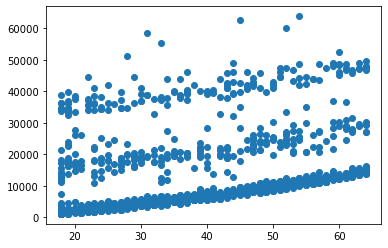

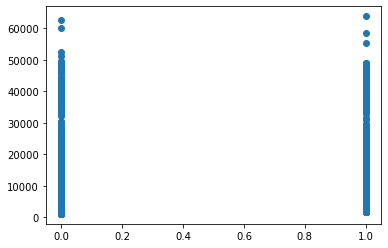

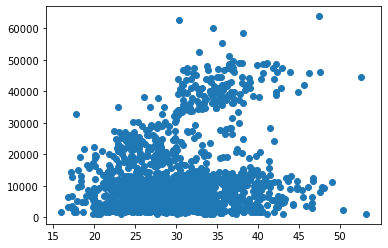

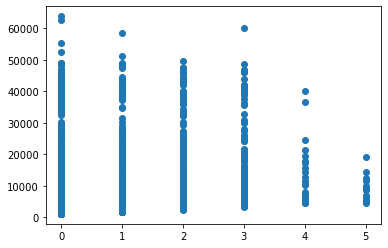

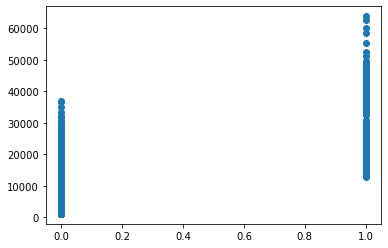

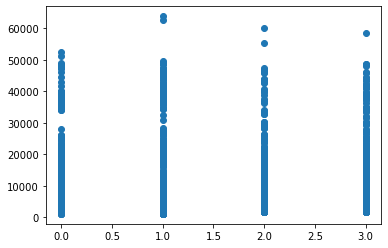

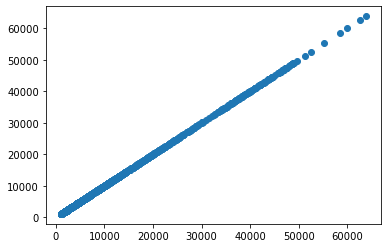

In [5]:
# now lets visually plot the dependent and independent variables 
# first lets see some scatter plots to understand dependencies
for (columnName, columnData) in df.iteritems(): 
    plt.scatter(columnData,df['charges'])
    plt.show()

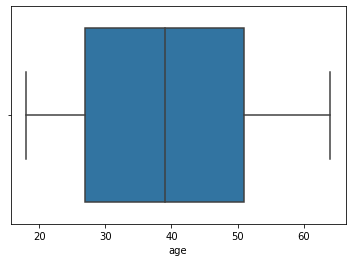

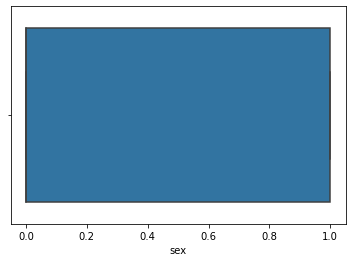

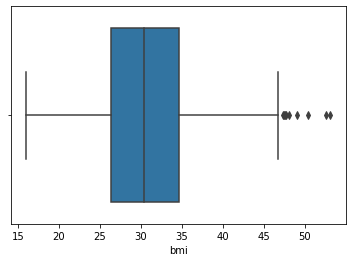

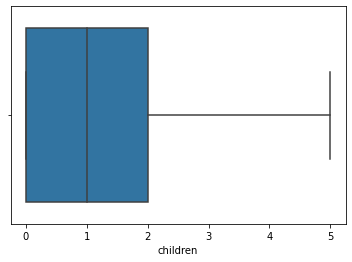

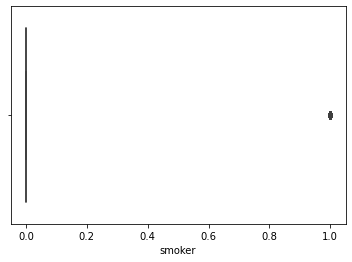

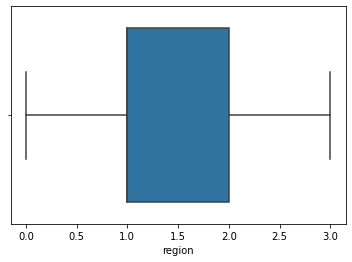

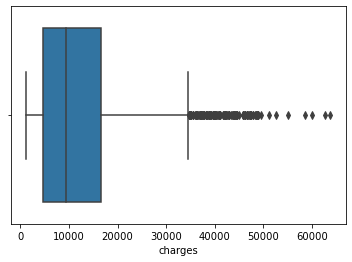

In [6]:
# next lets see box plots for outliers
for (columnName, columnData) in df.iteritems(): 
    sns.boxplot(df[columnName])
    plt.show()

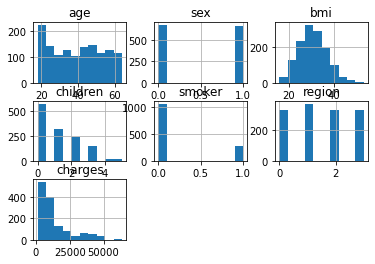

In [7]:
# from the above we see that BMI data and charges have some possible outliers (beyond the whisker in BMI and Charges)
# otherwise the box plots indicate significant data distribution between the 1st and 3rd quartiles

# now lets see the histogram plot for the dependent and independent variables
df.hist()
plt.show()

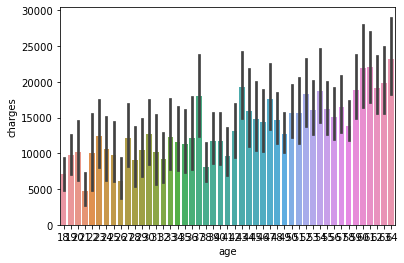

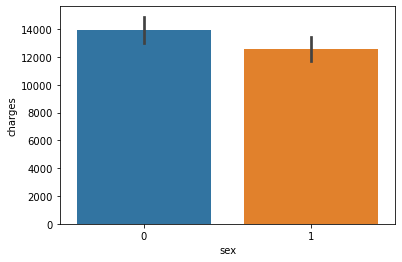

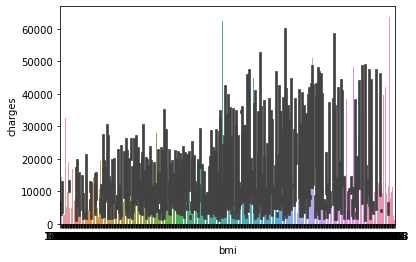

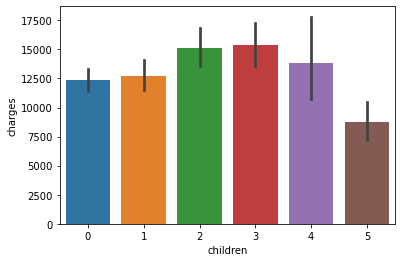

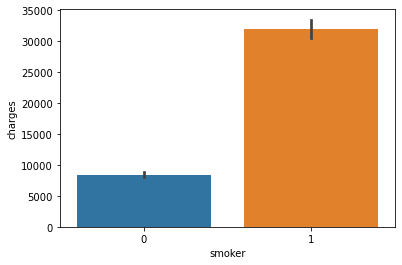

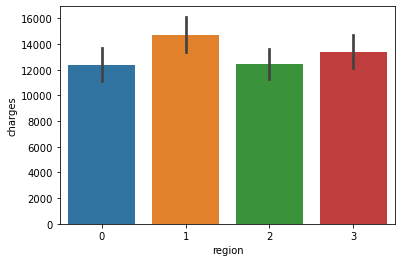

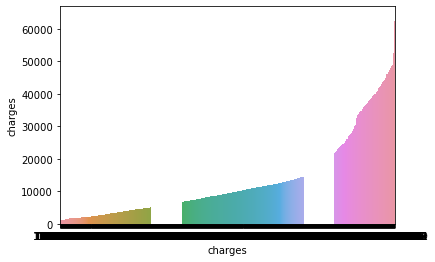

In [8]:
# now lets see the barplot (mix of box plot and histogram) for the dependent and independent variables
for (columnName, columnData) in df.iteritems(): 
    sns.barplot(x = columnName, y = 'charges', data = df)
    plt.show()


<AxesSubplot:>

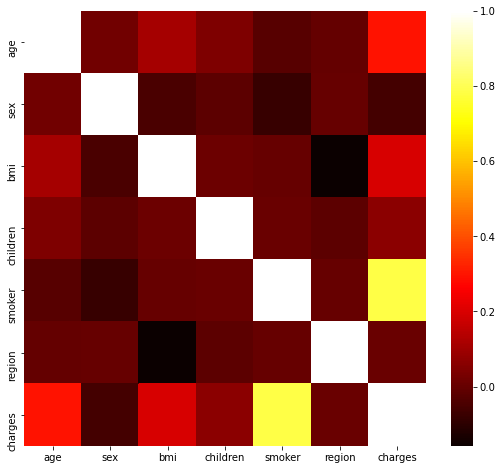

In [9]:
# lets see heat map for correlation between features and outputs
corrmat = df.corr() 
f, ax = plt.subplots(figsize =(9, 8)) 
sns.heatmap(corrmat, ax = ax, cmap ="hot") 

In [10]:
# in the above plot, the lighter the color, the stronger the coorelation between the variables
# in the above plot, the darker the color, the poorer the coorelation between the variables
# clearly, as seen in the last row of the above chart, charges has little coorelation with sex, region columns
# so, we are going to drop those 2 columns away from our data, so as to optimize the features involved
# also, just by inspection of the data, we see high correlation b/w feature 'smoker' and the output 'charges'!
df.drop(['sex'], axis=1, inplace = True)
df.drop(['region'], axis=1, inplace = True)
df

,age,bmi,children,smoker,charges
0,19,27.900,0,1,16884.92400
1,18,33.770,1,0,1725.55230
2,28,33.000,3,0,4449.46200
3,33,22.705,0,0,21984.47061
4,32,28.880,0,0,3866.85520
...,...,...,...,...,...
1333,50,30.970,3,0,10600.54830
1334,18,31.920,0,0,2205.98080
1335,18,36.850,0,0,1629.83350
1336,21,25.800,0,0,2007.94500


In [11]:
# now as all analysis, data preparation, feature removal are all done, we are set for modeling

# lets proceed with modelling using the Stochastic Gradient Descent model
# lets split the the given data into test and training data 
# we are using 1/3 of the data for training and 2/3 (0.66) for testing

features = ['age', 'bmi', 'children','smoker']
x = df.loc[:,features]
y = df['charges']

xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, random_state=0)

# now lets invoke the Stochastic Gradient Descent Regressor
sgdr = SGDRegressor()

# fit the model with the training data
sgdr.fit(xtrain, ytrain)

# predict through SGD the outcomes for the test data
ypred = sgdr.predict(xtest)

# print the mean squared error and variance score
# Ideal variance score is 1: 1 is perfect prediction!
# R^2 (coefficient of determination) regression score function.
mse = mean_squared_error(ytest, ypred)
print("MSE: ", mse)
print("RMSE: ", mse**0.5)
print("R2 : ", r2_score(ytest, ypred))

MSE:  1.4749833007715054e+19
RMSE:  3840551133.3290505
R2 :  -92690482623.86906


In [12]:
# lets proceed with modelling using the mini batch gradient descent model
# lets split the the given data into test and training data 
# we are using 1/3 of the data for training and 2/3 (0.66) for testing

features = ['age', 'bmi', 'children','smoker']
#x = df.loc[:,features]
x = df['bmi']
y = np.random.randn(df.shape[0],1)
for i in range(df.shape[0]):
    y[i]=df['charges'][i]
    
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, random_state=0)

def  cal_cost(theta,X,y):
    '''
    
    Calculates the cost for given X and Y. The following shows and example of a single dimensional X
    theta = Vector of thetas 
    X     = Row of X's np.zeros((2,j))
    y     = Actual y's np.zeros((2,1))
    
    where:
        j is the no of features
    '''
    
    m = len(y)
    
    predictions = X.dot(theta)
    cost = (1/2*m) * np.sum(np.square(predictions-y))
    return cost

def minibatch_gradient_descent(X,y,theta,learning_rate=0.01,iterations=10,batch_size =20):
    '''
    X    = Matrix of X without added bias units
    y    = Vector of Y
    theta=Vector of thetas np.random.randn(j,1)
    learning_rate 
    iterations = no of iterations
    
    Returns the final theta vector and array of cost history over no of iterations
    '''
    m = len(y)
    cost_history = np.zeros(iterations)
    n_batches = int(m/batch_size)
    
    for it in range(iterations):
        cost =0.0
        indices = np.random.permutation(m)
        X = X[indices]
        y = y[indices]
        for i in range(0,m,batch_size):
            X_i = X[i:i+batch_size]
            y_i = y[i:i+batch_size]
            
            X_i = np.c_[np.ones(len(X_i)),X_i]
           
            prediction = np.dot(X_i,theta)

            theta = theta -(1/m)*learning_rate*( X_i.T.dot((prediction - y_i)))
            cost += cal_cost(theta,X_i,y_i)
        cost_history[it]  = cost
        
    return theta, cost_history

lr =0.1
n_iter = 200

theta = np.random.randn(2,1)


theta,cost_history = minibatch_gradient_descent(x,y,theta,lr,n_iter)


# print the mean squared error and variance score
# Ideal variance score is 1: 1 is perfect prediction!
# R^2 (coefficient of determination) regression score function.
mse = mean_squared_error(ytest, ypred)
print("MSE: ", mse)
print("RMSE: ", mse**0.5)
print("R2 : ", r2_score(ytest, ypred))

MSE:  1.4749833007715054e+19
RMSE:  3840551133.3290505
R2 :  -92690482623.86906


In [13]:
# lets proceed with modelling using the gradient descent model
# lets split the the given data into test and training data 
# we are using 1/3 of the data for training and 2/3 (0.66) for testing

features = ['age', 'bmi', 'children','smoker']
#x = df.loc[:,features]
x = df['bmi']
y = np.random.randn(df.shape[0],1)
for i in range(df.shape[0]):
    y[i]=df['charges'][i]
    
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, random_state=0)

def gradient_descent(X,y,theta,learning_rate=0.01,iterations=100):
    '''
    X    = Matrix of X with added bias units
    y    = Vector of Y
    theta=Vector of thetas np.random.randn(j,1)
    learning_rate 
    iterations = no of iterations
    
    Returns the final theta vector and array of cost history over no of iterations
    '''
    m = len(y)
    cost_history = np.zeros(iterations)
    theta_history = np.zeros((iterations,2))
    for it in range(iterations):
        
        prediction = np.dot(X,theta)
        
        theta = theta -(1/m)*learning_rate*( X.T.dot((prediction - y)))
        theta_history[it,:] =theta.T
        cost_history[it]  = cal_cost(theta,X,y)
        
    return theta, cost_history, theta_history

lr =0.01
n_iter = 100

theta = np.random.randn(2,1)

X_b = np.c_[np.ones((len(x),1)),x]
theta,cost_history,theta_history = gradient_descent(X_b,y,theta,lr,n_iter)


# print the mean squared error and variance score
# Ideal variance score is 1: 1 is perfect prediction!
# R^2 (coefficient of determination) regression score function.
mse = mean_squared_error(ytest, ypred)
print("MSE: ", mse)
print("RMSE: ", mse**0.5)
print("R2 : ", r2_score(ytest, ypred))

MSE:  1.4749833007715054e+19
RMSE:  3840551133.3290505
R2 :  -92690482623.86906


In [14]:
# lets proceed with modelling using the normal equations using sk learn libraries
# lets split the the given data into test and training data 
# we are using 1/3 of the data for training and 2/3 (0.66) for testing

features = ['age', 'bmi', 'children','smoker']
#x = df.loc[:,features]
x = df['bmi']
y = np.random.randn(df.shape[0],1)
for i in range(df.shape[0]):
    y[i]=df['charges'][i]
    
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, random_state=0)

X_b = np.c_[np.ones((df.shape[0],1)),x]

theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

# print the mean squared error and variance score
# Ideal variance score is 1: 1 is perfect prediction!
# R^2 (coefficient of determination) regression score function.
mse = mean_squared_error(ytest, ypred)
print("MSE: ", mse)
print("RMSE: ", mse**0.5)
print("R2 : ", r2_score(ytest, ypred))

MSE:  1.4749833007715054e+19
RMSE:  3840551133.3290505
R2 :  -92690482623.86906
